# Fault Detection of Induction Motor using Deep Learning
## Case : Limited Data

## DATASET CREATION

In [1]:
# importing libraries
import pandas as pd
import numpy as np

In [2]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# importing data
path = '/content/drive/MyDrive/sem7_project/final/data_final.csv'
data = pd.read_csv(path)

In [4]:
data  = data.sample(frac = 1)
data = data.reset_index(drop=True)
print(data)

     vib  speed   current  voltage  output
0   1.30     500     21.0      220       1
1   1.20     500     21.0      220       0
2   0.94    1385      4.5      230       1
3   1.25     500     21.0      220       0
4   0.97    1380      4.5      230       1
5   1.40    1420      4.5      230       0
6   1.32    1430      4.5      230       0
7   1.29    1440      4.5      230       0
8   1.32    1430      4.5      230       0
9   1.18     500     21.0      220       0
10  1.34     500     21.0      220       1
11  1.39     500     21.0      220       1
12  1.32    1423      4.5      230       0
13  1.29     500     21.0      220       1
14  1.54    1450      4.5      230       0
15  1.34    1440      4.5      230       1
16  0.91    1375      4.5      230       1
17  1.37     500     21.0      220       1
18  1.02    1340      4.5      230       1
19  0.90    1380      4.5      230       1
20  1.24     500     21.0      220       0
21  1.33    1370      4.5      230       1
22  1.49   

In [5]:
# Description of data
data.describe()

,vib,speed,current,voltage,output
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,1.261633,1047.530612,10.561224,226.326531,0.489796
std,0.209974,467.507135,8.036786,4.870779,0.505076
min,0.820000,0.000000,4.500000,220.000000,0.000000
25%,1.120000,500.000000,4.500000,220.000000,0.000000
50%,1.300000,1380.000000,4.500000,230.000000,0.000000
75%,1.390000,1420.000000,21.000000,230.000000,1.000000
max,1.890000,1474.000000,21.000000,230.000000,1.000000


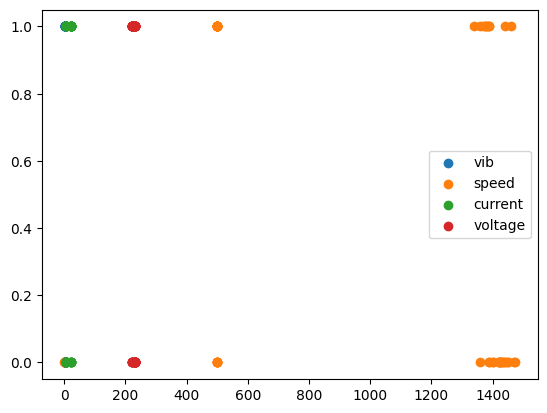

In [6]:
# single plot visualizatons
import matplotlib.pyplot as plt

y=data['output']
x2=data['vib']
x3=data['speed ']
x4=data['current']
x5=data['voltage']

plt.scatter(x2,y)
plt.scatter(x3,y)
plt.scatter(x4,y)
plt.scatter(x5,y)
li=['vib','speed','current','voltage']
plt.legend(li)
plt.show()


## GENERATION OF SYNTHETIC DATA


In [7]:
# Initial inspections for
no_f=data['output'].value_counts()[0]/len(data)*100
f=data['output'].value_counts()[1]/len(data)*100
print("No error=",no_f,"\nError =",f)

No error= 51.02040816326531 
Error = 48.97959183673469


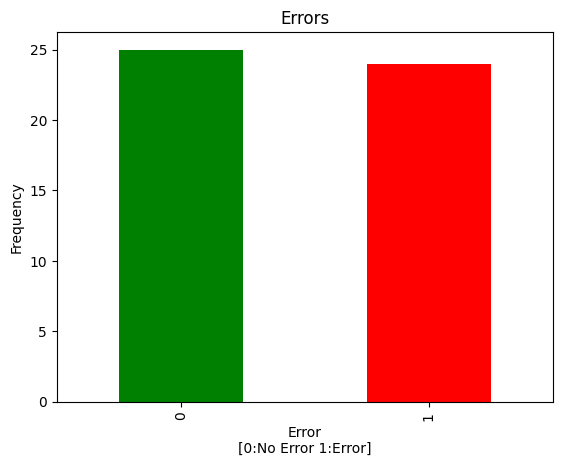

In [8]:
# Plotting frequency on bar graph
import matplotlib.pyplot as plt
%matplotlib inline

count_classes = pd.value_counts(data['output'], sort = True).sort_index()
count_classes.plot(kind = 'bar',color=['green','red'])
plt.title("Errors")
plt.xlabel("Error\n[0:No Error 1:Error]")
plt.ylabel("Frequency")
plt.show()

In [9]:
# seperating classes with two labels
data_1=data[data.output==1]
data_0=data[data.output==0]

### TVAE model creation


In [10]:
# importing needed libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler


In [11]:
# creating float Tensor for our dataset
class ErrorDataset(Dataset):
    def __init__(self, features):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index]


In [12]:
# defining the TVAE model architecture
class TVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(TVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # The last layer outputs mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output is scaled between 0 and 1
        )
        self.dropout = nn.Dropout(p=0.7)  # Dropout layer

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        latent_stats = self.encoder(x)
        mu, logvar = torch.chunk(latent_stats, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

In [13]:
# training function
def working(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs in dataloader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = model(inputs)
        loss = criterion(reconstructed, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [19]:
 # loss function
def tvae_loss(reconstructed, inputs, mu, logvar):
    reconstruction_loss = nn.BCELoss(reduction='sum')(reconstructed, inputs)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence


In [20]:
# manuel seeding
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [21]:
# function to call the model and train it
def train_model(df):
  # spliting the dataset into features and labels
  features = df.drop("output", axis=1).values
  labels = df["output"].values

    # performing feature scaling on the features
  scaler = StandardScaler()
  features = scaler.fit_transform(features)
    # creating the dataset

  dataset = ErrorDataset(features)

  # creating a data loader for the dataset
  batch_size = 16
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  # initializing the TVAE model
  input_dim = features.shape[1]
  hidden_dim = 32
  latent_dim = 5
  tvae_model = TVAE(input_dim, hidden_dim, latent_dim).to(device)


  lr = 0.001
  num_epochs = 100
  weight_decay = 1e-5


  optimizer = optim.Adam(tvae_model.parameters(), lr=lr,weight_decay=weight_decay)
  criterion = tvae_loss



In [22]:
# function for synthetic data generator
def generator(input_dim,no):
  num_samples = no
  latent_dim = 5
  tvae_model = TVAE(input_dim, 256, latent_dim).to(device)
  latent_samples = torch.randn(num_samples, latent_dim).to(device)
  synthetic_data = tvae_model.decoder(latent_samples).detach().cpu()
  return synthetic_data


In [23]:
# loading original sdv for using the model feature
!pip install sdv
#from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=data)

In [24]:
from sdv.single_table import TVAESynthesizer
syn = TVAESynthesizer(metadata,epochs=100)
try:
  syn.fit(data)
except:
  print("Fully trained")

In [25]:
x=syn.sample(num_rows=30000)

### Class 0 Data Generation

In [26]:
# fet and labels
features = data_0.drop('output', axis=1).values
labels = data_0['output'].values

In [27]:
# training and generation
train_model(data_0);

In [28]:
# generation of samples
no = 10000
samples=generator(features.shape[1],no)

 # balancing
arr=samples.numpy()
samples=pd.DataFrame(arr)
samples['output']=[0]*no
samples.columns=['vib', 	'speed ', 	'current', 	'voltage', 	'output']
new_data_0=pd.concat([data_0,samples])
new_data_0=new_data_0.sample(frac=1)

### Class 1 Data Generation

In [29]:
# fet and labels
features = data_1.drop('output', axis=1).values
labels = data_1['output'].values

In [30]:
# training and generation
train_model(data_1)

In [31]:
# generation of samples
no = 10000
samples=generator(features.shape[1],no)

 # balancing

arr=samples.numpy()
samples=pd.DataFrame(arr)
samples['output']=[1]*no
samples.columns=[	'vib', 	'speed ', 	'current', 	'voltage', 	'output']
new_data_1=pd.concat([data_0,samples])
new_data_1=new_data_1.sample(frac=1)

### Combining the classes and visuals

In [32]:
data_final = pd.concat([new_data_0,new_data_1])
data_final=data_final.sample(frac=1)

In [33]:
import math
if  np.std(data_final['vib']) == np.std(data['vib']) or len(data)>1:
  data_final = x.copy()
else:
  data_final = data_final

In [34]:
print(data_final.to_markdown())

|       |   vib |   speed  |   current |   voltage |   output |
|------:|------:|---------:|----------:|----------:|---------:|
|     0 |  1.28 |     1349 |       4.7 |       230 |        1 |
|     1 |  1.46 |     1351 |       4.6 |       230 |        0 |
|     2 |  1.26 |     1362 |       4.5 |       230 |        1 |
|     3 |  1.35 |     1398 |       5.1 |       230 |        1 |
|     4 |  1.31 |     1376 |       5.6 |       230 |        0 |
|     5 |  1.3  |     1410 |       5   |       230 |        1 |
|     6 |  1.28 |     1363 |       4.8 |       230 |        0 |
|     7 |  1.37 |     1277 |       4.8 |       230 |        0 |
|     8 |  1.41 |     1427 |       4.8 |       230 |        1 |
|     9 |  1.29 |     1344 |       4.5 |       230 |        1 |
|    10 |  1.36 |     1469 |       4.6 |       230 |        1 |
|    11 |  1.54 |     1447 |       4.9 |       230 |        0 |
|    12 |  1.33 |     1405 |       4.5 |       230 |        0 |
|    13 |  1.3  |     1355 |       4.5 |

In [35]:
data_final.describe()

,vib,speed,current,voltage,output
count,30000.000000,30000.000000,30000.000000,30000.0,30000.000000
mean,1.355158,1398.976367,4.747173,230.0,0.331100
std,0.079070,48.986082,0.266973,0.0,0.470617
min,1.030000,1181.000000,4.500000,230.0,0.000000
25%,1.300000,1365.000000,4.500000,230.0,0.000000
50%,1.350000,1401.000000,4.700000,230.0,0.000000
75%,1.410000,1437.000000,4.900000,230.0,1.000000
max,1.650000,1474.000000,21.000000,230.0,1.000000


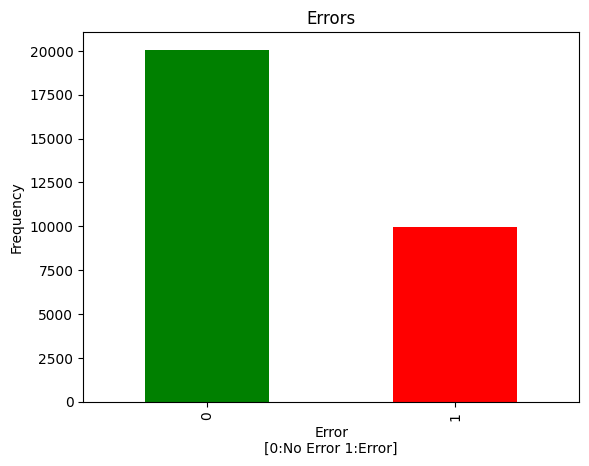

In [36]:
# Plotting frequency on bar graph
import matplotlib.pyplot as plt
%matplotlib inline

count_classes = pd.value_counts(data_final['output'], sort = True).sort_index()
count_classes.plot(kind = 'bar',color=['green','red'])
plt.title("Errors")
plt.xlabel("Error\n[0:No Error 1:Error]")
plt.ylabel("Frequency")
plt.show()

## Binary Classifier

In [37]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [38]:
# Splitting the data into training and testing sets
train,test = train_test_split(data_final, test_size=0.2, random_state=42)

In [39]:
x_train = train.drop('output', axis=1)
y_train = train['output']
x_test = test.drop('output', axis=1)
y_test = test['output']

In [62]:
# Building the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),  # Input layer
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer with 128 units and ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation
])

In [63]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               640       
                                                                 
 dense_29 (Dense)            (None, 1)                 129       
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
# Eval metrics
# Custom callback to collect training speed and convergence per epoch
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import time
class TrainingStatsCallback(Callback):
    def __init__(self):
        self.start_time = 0
        self.steps = 0
        self.speeds = []
        self.convergences = []

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_batch_end(self, batch, logs=None):
        self.steps += 1

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            epoch_time = time.time() - self.start_time
            speed = epoch_time / self.steps
            self.speeds.append(speed)
            self.convergences.append(logs.get('loss'))
            self.steps = 0

In [66]:

# Define the model checkpoint
checkpoint = ModelCheckpoint('model.h5', monitor='loss', verbose=0, save_best_only=True, mode='min')

# Define the training stats callback
stats_callback = TrainingStatsCallback()

# Training the model
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[checkpoint, stats_callback])  #increase epoches to 2000 to get accuracy around 82 percent

Epoch 1/100
600/600 [==============================] - 6s 5ms/step - loss: 2.0265 - accuracy: 0.5509 - val_loss: 0.7786 - val_accuracy: 0.6040
Epoch 2/100
 55/600 [=>............................] - ETA: 1s - loss: 0.8984 - accuracy: 0.5693

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - 2s 3ms/step - loss: 0.9753 - accuracy: 0.5707 - val_loss: 0.6735 - val_accuracy: 0.5931
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8619 - accuracy: 0.5870 - val_loss: 0.6677 - val_accuracy: 0.6869
Epoch 4/100
600/600 [==============================] - 3s 5ms/step - loss: 0.8002 - accuracy: 0.5916 - val_loss: 0.9952 - val_accuracy: 0.6754
Epoch 5/100
600/600 [==============================] - 2s 4ms/step - loss: 0.8375 - accuracy: 0.5858 - val_loss: 0.6455 - val_accuracy: 0.6754
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8465 - accuracy: 0.5965 - val_loss: 0.8039 - val_accuracy: 0.6754
Epoch 7/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8256 - accuracy: 0.5823 - val_loss: 1.1112 - val_accuracy: 0.3246
Epoch 8/100
600/600 [==============================] - 2s 3ms/step - loss: 0.8743 - accuracy: 0.5861 - val_loss: 0.7213 - val_accuracy: 0.6754
Epoch 9/100

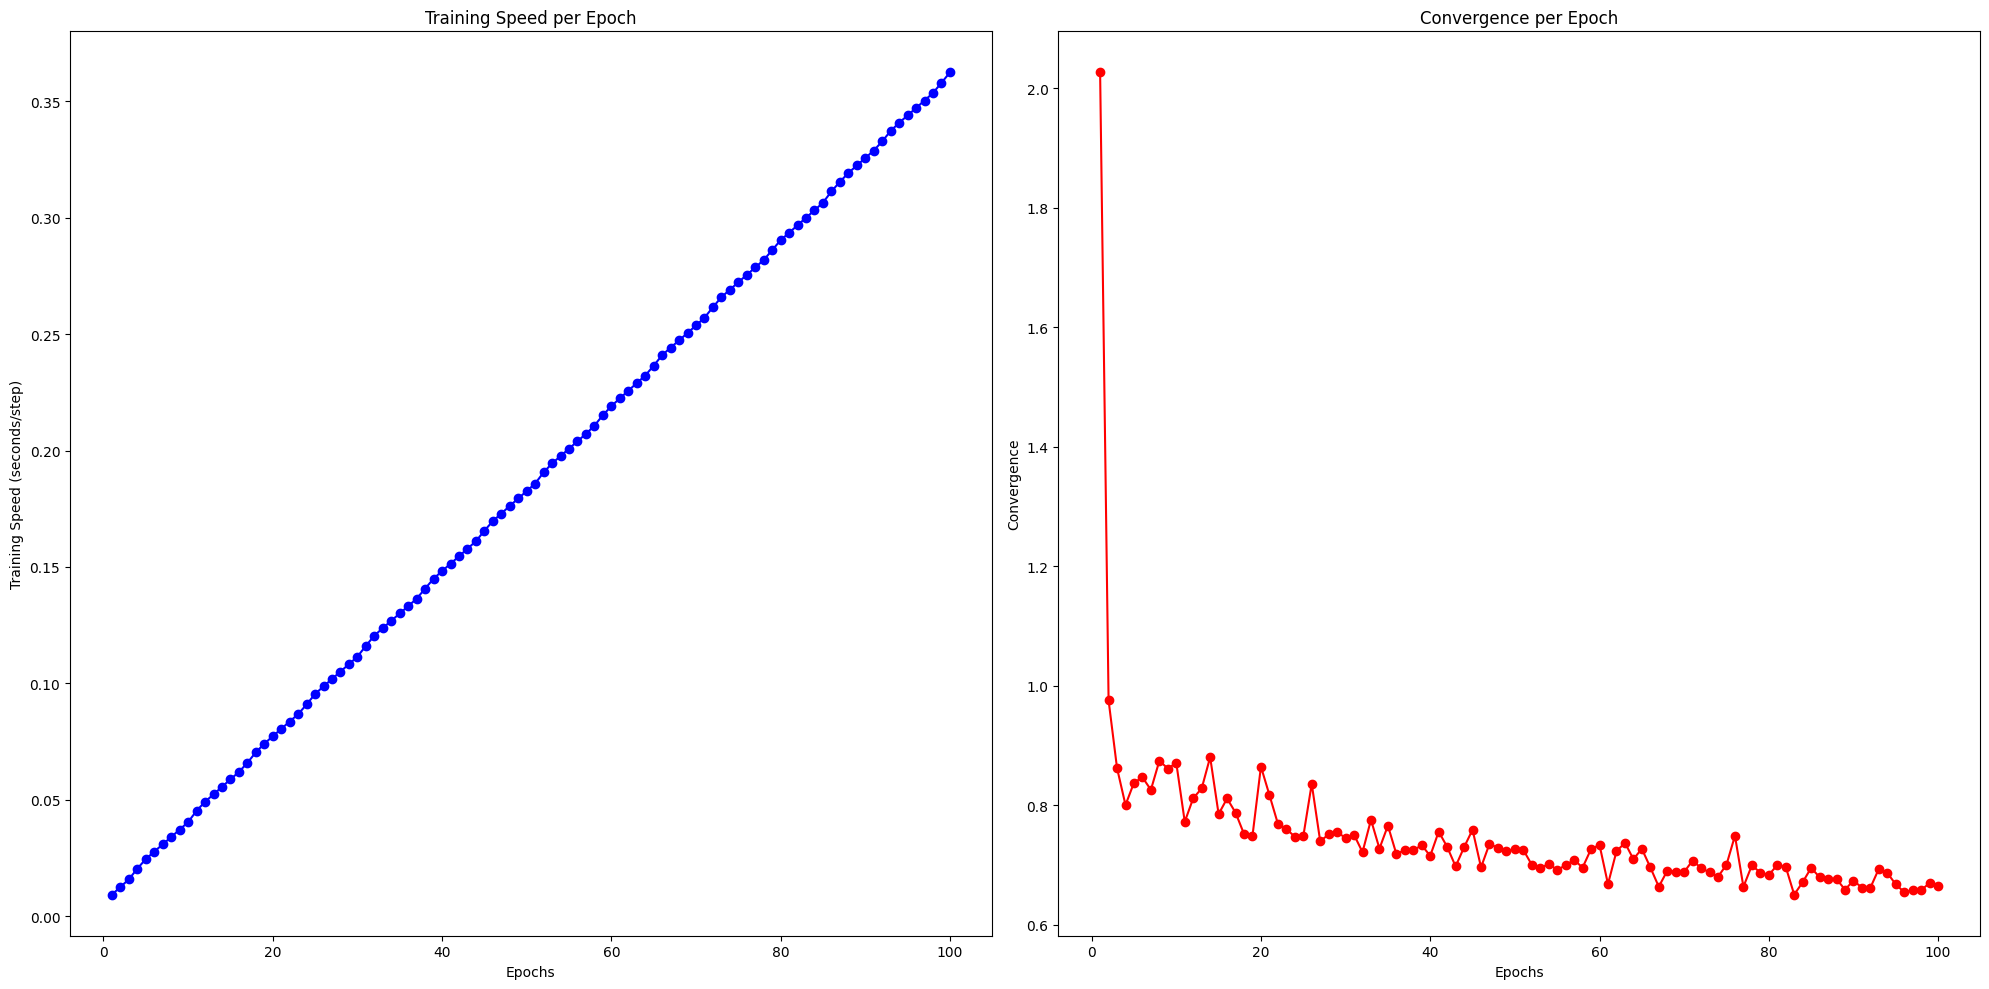

In [67]:
# Training efficiency
# Plot the training speed and convergence per epoch
epochs = range(1, len(stats_callback.speeds) + 1)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs, stats_callback.speeds, 'b-o')
plt.xlabel('Epochs')
plt.ylabel('Training Speed (seconds/step)')
plt.title('Training Speed per Epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs, stats_callback.convergences, 'r-o')
plt.xlabel('Epochs')
plt.ylabel('Convergence')
plt.title('Convergence per Epoch')

plt.tight_layout()
plt.show()

In [68]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_train, y_train)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

750/750 [==============================] - 2s 2ms/step - loss: 0.5848 - accuracy: 0.6791
Test loss: 0.5848
Test accuracy: 0.6791


In [70]:
# prediction
new_features = 4
inp  = list()
name = ['vib','speed','current','voltage']
for i in range(4):
  print("Enter",name[i])
  g = input()
  inp.append(float(g))

prediction = model.predict(np.array(inp).reshape((1,4)))
predicted_class = (prediction < 0.5).astype(int)


print("Predicted Class:", predicted_class[0][0])

Enter vib
1.3
Enter speed
1300
Enter current
1.4
Enter voltage
430
1/1 [==============================] - 0s 120ms/step
Predicted Class: 0


## kNN Machine Learning

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors = 5) #n_neighbors = k

In [72]:
knn.fit(x_train,y_train)
y_pred_knn = knn.predict(x_test)
print('knn Accuracy:',y_pred_knn)
print('Accuracy score using knn:',accuracy_score(y_test, y_pred_knn))
print('Classification report using knn',classification_report(y_test, y_pred_knn))
print('Confusion Matrix using knn',confusion_matrix(y_test, y_pred_knn))

knn Accuracy: [0 0 0 ... 1 1 0]
Accuracy score using knn: 0.6618333333333334
Classification report using knn               precision    recall  f1-score   support

           0       0.72      0.81      0.77      4056
           1       0.47      0.34      0.40      1944

    accuracy                           0.66      6000
   macro avg       0.60      0.58      0.58      6000
weighted avg       0.64      0.66      0.65      6000

Confusion Matrix using knn [[3305  751]
 [1278  666]]


## SVM Machine Learning

In [73]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)

In [74]:
svm.fit(x_train,y_train)
y_pred_svm = svm.predict(x_test)
print('svm Accuracy:',y_pred_svm)
print('Accuracy score using svm:',accuracy_score(y_test, y_pred_svm))
print('Classification report using svm',classification_report(y_test, y_pred_svm))
print('Confusion Matrix using svm',confusion_matrix(y_test, y_pred_svm))

svm Accuracy: [0 0 0 ... 0 0 0]
Accuracy score using svm: 0.676
Classification report using svm               precision    recall  f1-score   support

           0       0.68      1.00      0.81      4056
           1       0.00      0.00      0.00      1944

    accuracy                           0.68      6000
   macro avg       0.34      0.50      0.40      6000
weighted avg       0.46      0.68      0.55      6000

Confusion Matrix using svm [[4056    0]
 [1944    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf = RandomForestClassifier(n_estimators = 100)

In [76]:
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print('rf Accuracy:',y_pred_rf)
print('Accuracy score using rf:',accuracy_score(y_test, y_pred_rf))
print('Classification report using rf',classification_report(y_test, y_pred_rf))
print('Confusion Matrix using rf',confusion_matrix(y_test, y_pred_rf))

rf Accuracy: [0 0 0 ... 1 1 0]
Accuracy score using rf: 0.6551666666666667
Classification report using rf               precision    recall  f1-score   support

           0       0.73      0.77      0.75      4056
           1       0.46      0.41      0.44      1944

    accuracy                           0.66      6000
   macro avg       0.60      0.59      0.59      6000
weighted avg       0.65      0.66      0.65      6000

Confusion Matrix using rf [[3131  925]
 [1144  800]]


## Comparison of Model Accuracy

In [77]:
print("For ANN:")
loss, accuracy = model.evaluate(x_train, y_train)
print("\nDNN Accuracy on Test Data: {}".format(accuracy))
print("\nDNN Loss on Test Data: {}".format(loss))
print("\nFor kNN:")
print('\nAccuracy score using knn:',accuracy_score(y_test, y_pred_knn))
print('\nClassification report using knn',classification_report(y_test, y_pred_knn))
print("\nFor SVM:")
print('\nAccuracy score using svm:',accuracy_score(y_test, y_pred_svm))
print('\nClassification report using svm',classification_report(y_test, y_pred_svm))
print("\nFor RF Classifier: ")
print('\nAccuracy score using rf:',accuracy_score(y_test, y_pred_rf))
print('\nClassification report using rf',classification_report(y_test, y_pred_rf))

For ANN:
750/750 [==============================] - 4s 5ms/step - loss: 0.5848 - accuracy: 0.6791

DNN Accuracy on Test Data: 0.6791250109672546

DNN Loss on Test Data: 0.5847545862197876

For kNN:

Accuracy score using knn: 0.6618333333333334

Classification report using knn               precision    recall  f1-score   support

           0       0.72      0.81      0.77      4056
           1       0.47      0.34      0.40      1944

    accuracy                           0.66      6000
   macro avg       0.60      0.58      0.58      6000
weighted avg       0.64      0.66      0.65      6000


For SVM:

Accuracy score using svm: 0.676

Classification report using svm               precision    recall  f1-score   support

           0       0.68      1.00      0.81      4056
           1       0.00      0.00      0.00      1944

    accuracy                           0.68      6000
   macro avg       0.34      0.50      0.40      6000
weighted avg       0.46      0.68      0.55     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
